<a href="https://colab.research.google.com/github/OmkarPatolee/work/blob/main/OP_BL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)

In [71]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

In [72]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [73]:
tickers = [
    'TLT',  # US Government Bonds (iShares 20+ Year Treasury Bond ETF)
    'MBB',  # US Mortgages ETF
    'IWN',  # U.S. Small-Cap Value Equities (iShares Russell 2000 ETF)
    'IWO',  # U.S. Small-Cap Growth Equities (iShares Russell 2000 ETF)
    'IWD',  # U.S. Large-Cap Value (iShares Russell 1000 Value ETF)
    'MCHI',  # Chinese Equities(ishares MSCI)
    'INDY',  # Indian Equities (NIFTY Index)
    'XLV',  # Healthcare (Health Care Select Sector SPDR Fund)
    'XLE',  # Energy (Energy Select Sector SPDR Fund)
    'XLY',  # Consumer Discretionary (Consumer Discretionary Select Sector SPDR Fund)
    'XLF',  # Financials (Financials Select Sector SPDR Fund)
]

In [74]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  11 of 11 completed


Ticker,INDY,IWD,IWN,IWO,MBB,MCHI,TLT,XLE,XLF,XLV,XLY
Date,,,,,,,,,,,
2024-09-30 00:00:00+00:00,56.299999,189.800003,166.820007,284.000000,95.499001,50.910000,97.783997,87.800003,45.320000,154.020004,200.369995
2024-10-01 00:00:00+00:00,56.029999,189.059998,164.380005,280.279999,95.809998,52.980000,98.489998,89.800003,45.080002,153.210007,199.559998
2024-10-02 00:00:00+00:00,55.860001,189.039993,163.860001,280.769989,95.680000,56.480000,97.660004,90.720001,45.130001,152.899994,197.869995
2024-10-03 00:00:00+00:00,55.220001,188.240005,163.000000,278.190002,95.209999,54.990002,96.739998,92.320000,44.889999,151.520004,195.580002
2024-10-04 00:00:00+00:00,55.070000,189.619995,165.050003,282.869995,94.510002,57.000000,95.550003,93.180000,45.650002,151.639999,198.169998


In [75]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
1993-01-29,24.608624
1993-02-01,24.783648
1993-02-02,24.836159
1993-02-03,25.098684
1993-02-04,25.203716


In [76]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    info = stock.info

    # Try to get market capitalization first, if not available, use totalAssets for ETFs
    if 'marketCap' in info:
        mcaps[t] = info['marketCap']  # For regular stocks
    elif 'totalAssets' in info:
        mcaps[t] = info['totalAssets']  # For ETFs, use total assets (AUM)
    else:
        print(f"Market Cap or Total Assets not available for {t}, assigning default value.")
        mcaps[t] = 1e9  # Assigning a default value, e.g., $1 billion

mcaps

{'TLT': 61026795520,
 'MBB': 34353930240,
 'IWN': 12552940544,
 'IWO': 12063725568,
 'IWD': 60449714176,
 'MCHI': 5340214784,
 'INDY': 1004747200,
 'XLV': 41938018304,
 'XLE': 35469139968,
 'XLY': 19484006400,
 'XLF': 42114596864}

## Constructing the prior

In [77]:
import pypfopt
pypfopt.__version__

'1.5.5'

In [78]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.78622208742861

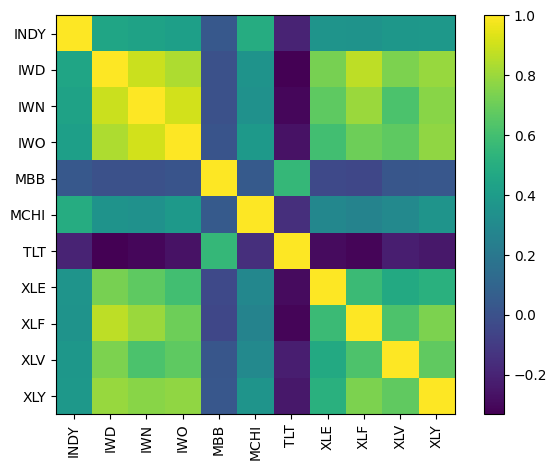

In [79]:
plotting.plot_covariance(S, plot_correlation=True);

In [80]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

,0
Ticker,
INDY,0.048586
IWD,0.085910
IWN,0.095589
IWO,0.096103
MBB,0.021777
MCHI,0.046217
TLT,0.012817
XLE,0.101421
XLF,0.113500


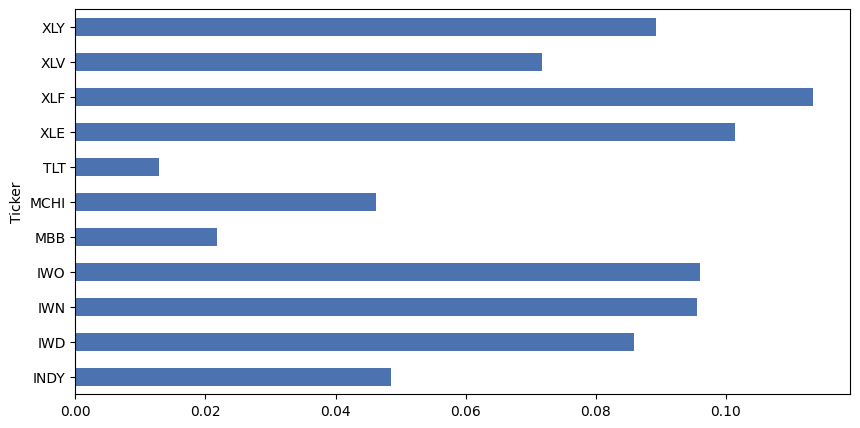

In [81]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [82]:
#Exp_returns and volatility
# Define the date range (last 2 years)
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y-%m-%d')

# Download adjusted close price data for the tickers
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate the mean daily returns and volatility (standard deviation) for each asset
mean_daily_returns = returns.mean()
daily_volatility = returns.std()

# Annualize the mean returns and volatility
trading_days = 252  # Approximate number of trading days in a year
annualized_returns = mean_daily_returns * trading_days
annualized_volatility = daily_volatility * np.sqrt(trading_days)

# Calculate the covariance matrix for the asset classes (daily)
cov_matrix_daily = returns.cov()

# Annualize the covariance matrix
cov_matrix_annualized = cov_matrix_daily * trading_days

# Display results
print("Annualized Returns:\n", annualized_returns)
print("\nAnnualized Volatility:\n", annualized_volatility)
print("\nAnnualized Covariance Matrix:\n", cov_matrix_annualized)

[*********************100%***********************]  11 of 11 completed


Annualized Returns:
 Ticker
INDY    0.152209
IWD     0.165850
IWN     0.134597
IWO     0.150562
MBB     0.057630
MCHI    0.173818
TLT     0.021324
XLE     0.125524
XLF     0.199961
XLV     0.112465
XLY     0.175367
dtype: float64

Annualized Volatility:
 Ticker
INDY    0.125635
IWD     0.133387
IWN     0.212261
IWO     0.216349
MBB     0.080619
MCHI    0.295666
TLT     0.173328
XLE     0.220075
XLF     0.159770
XLV     0.119825
XLY     0.208918
dtype: float64

Annualized Covariance Matrix:
 Ticker      INDY       IWD       IWN       IWO       MBB      MCHI       TLT  \
Ticker                                                                         
INDY    0.015784  0.008523  0.012389  0.013370  0.001625  0.011236  0.001841   
IWD     0.008523  0.017792  0.025050  0.024898  0.002615  0.014602  0.003483   
IWN     0.012389  0.025050  0.045055  0.043021  0.004577  0.021794  0.006150   
IWO     0.013370  0.024898  0.043021  0.046807  0.004854  0.023368  0.006696   
MBB     0.001625  0.0026

In [83]:

# Convert the annualized returns to a dictionary
annualized_returns_dict = annualized_returns.to_dict()

# Define your absolute views using the values from the 'annualized_returns' variable
# From my capital market Expectations I expect the given asset classes can provide a return which is atleast the mean.

viewdict = {ticker: annualized_returns_dict[ticker] for ticker in annualized_returns_dict}

# Now pass this into the Black-Litterman model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

print("Views:", viewdict)


Views: {'INDY': 0.15220946178456346, 'IWD': 0.16585004110791615, 'IWN': 0.13459733328432008, 'IWO': 0.1505620400021065, 'MBB': 0.05762964296301872, 'MCHI': 0.17381838845859096, 'TLT': 0.02132419498553652, 'XLE': 0.12552355954991967, 'XLF': 0.19996127805886418, 'XLV': 0.11246511396783668, 'XLY': 0.17536656428954558}


Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [121]:
confidences = [
    0.4,#INDY
    0.7,#IWD
    0.45,#IWM
    0.55,#IWO
    0.35, #MBB
    0.65, #MCHI
    0.45, #TLT
    0.7, #XLE
    0.6, #XLF
    0.32, #XLV
    0.45 #XLY
]

In [122]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)


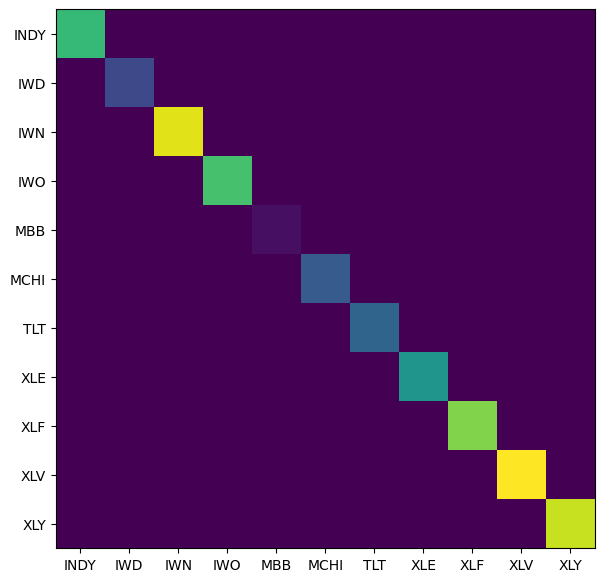

In [123]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [124]:
np.diag(bl.omega)

array([0.0022915 , 0.00075294, 0.00326971, 0.00243131, 0.00014288,
       0.00098763, 0.00110754, 0.00178778, 0.00276981, 0.00342484,
       0.00314012])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [125]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega="idzorek",view_confidences=confidences)

In [126]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

,0
Ticker,
INDY,0.107528
IWD,0.140720
IWN,0.156154
IWO,0.163709
MBB,0.022649
MCHI,0.132859
TLT,0.013943
XLE,0.142627
XLF,0.187230


We can visualise how this compares to the prior and our views:

In [127]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
INDY,0.048586,0.107528,0.152209
IWD,0.085910,0.140720,0.165850
IWN,0.095589,0.156154,0.134597
IWO,0.096103,0.163709,0.150562
MBB,0.021777,0.022649,0.057630
MCHI,0.046217,0.132859,0.173818
TLT,0.012817,0.013943,0.021324
XLE,0.101421,0.142627,0.125524
XLF,0.113500,0.187230,0.199961
XLV,0.071771,0.112682,0.112465


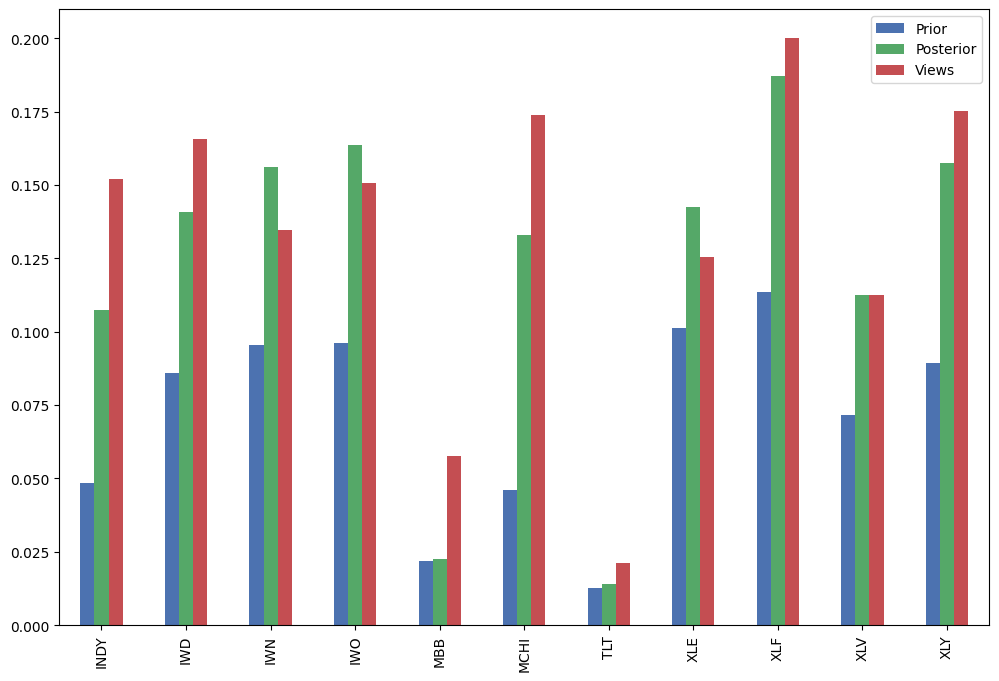

In [128]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

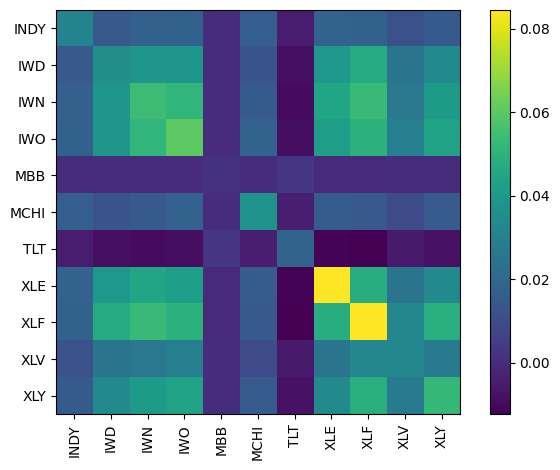

In [129]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [130]:
from pypfopt import EfficientFrontier, objective_functions

In [131]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('INDY', 0.08314),
             ('IWD', 0.10608),
             ('IWN', 0.1172),
             ('IWO', 0.125),
             ('MBB', 0.00304),
             ('MCHI', 0.11245),
             ('TLT', 0.00127),
             ('XLE', 0.10139),
             ('XLF', 0.14608),
             ('XLV', 0.0818),
             ('XLY', 0.12255)])

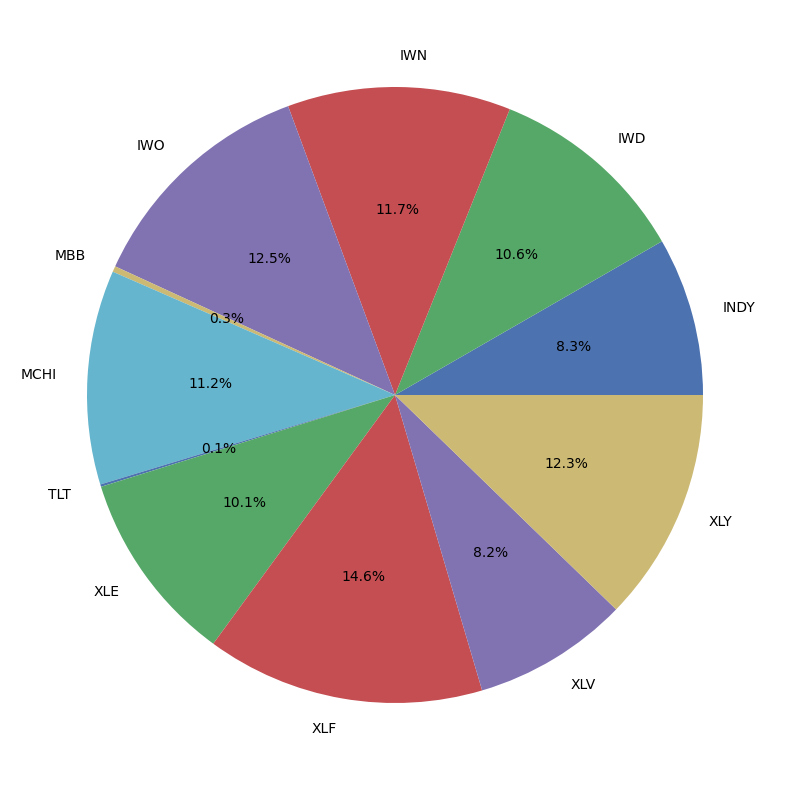

In [132]:
pd.Series(weights).plot.pie(figsize=(10,10,),autopct='%1.1f%%');

In [133]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=6000000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $105.20


{'INDY': 9058,
 'IWD': 3357,
 'IWN': 4260,
 'IWO': 2651,
 'MBB': 193,
 'MCHI': 11837,
 'TLT': 80,
 'XLE': 6529,
 'XLF': 19200,
 'XLV': 3237,
 'XLY': 3710}